In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import GridSearchCV
import xgboost as xgb



---


#ПОСМОТРИМ НА ДАННЫЕ

In [ ]:
data = pd.read_csv("train.csv", index_col=False)
data.head(5)

,id,plate,date,price
0,1,X059CP797,2024-12-26 00:00:00,65000
1,2,Y800MH790,2024-07-12 21:31:37,100000
2,3,A212TX77,2024-04-18 00:00:00,290000
3,4,P001AY199,2025-01-03 00:27:15,680000
4,5,P001AY199,2025-01-10 09:32:41,750000


In [ ]:
data.shape

(51635, 4)

In [ ]:
print(len(data["plate"]) - len(set(data["plate"])))

8030


#В ДАННЫХ ИМЕЮТСЯ ДУБЛИКАТЫ 8030шт. А ТОЧНЕЕ , ЭТО ПЕРЕЗАКУПКИ НОМЕРОВ. Т.Е. КОГДА ОДИН НОМЕР БЫЛ ПРОДАН , А В ДАТАФРЕЙМЕ ДАННЫЕ О ВСЕХ ПОКУПКАХ

<ipython-input-215-db8040c463b7>:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


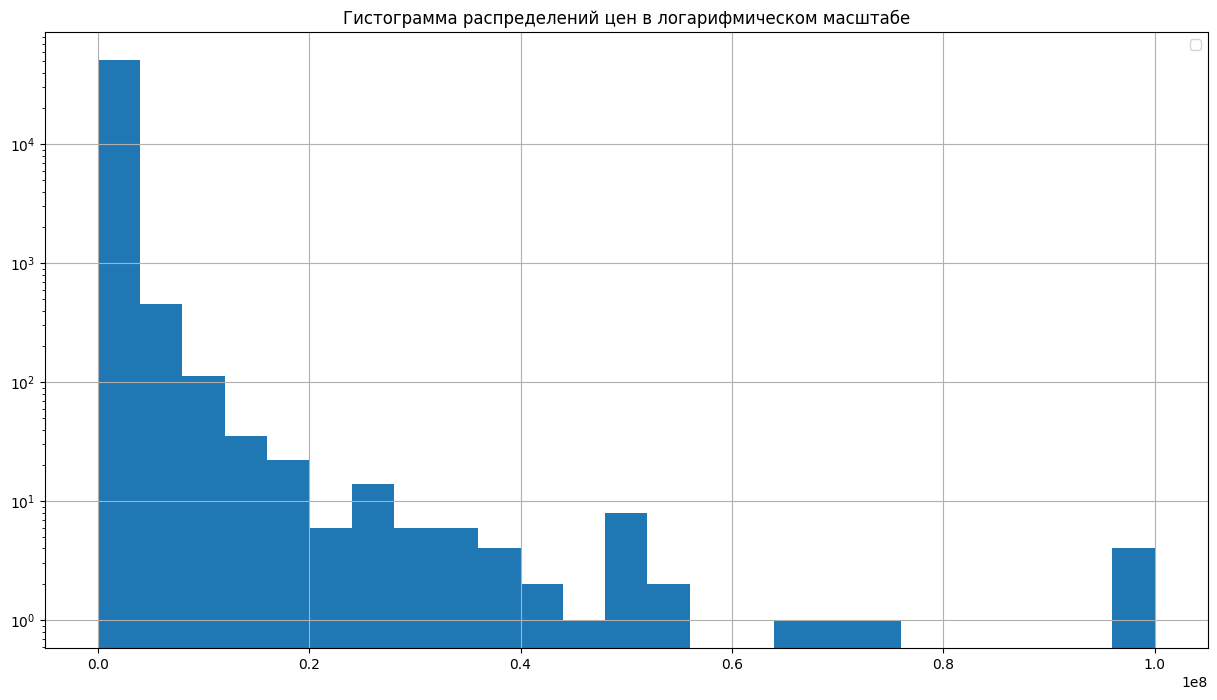

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(data["price"], bins=25, log=True)
plt.title("Гистограмма распределений цен в логарифмическом масштабе")
plt.legend()
plt.grid(True)

#ПОСМОТРИМ НА РАСПРЕДЕЛЕНИЕ ЦЕН В ЗАВИСИМОСТИ ОТ ГОРОДА

Text(0, 0.5, 'Цена')

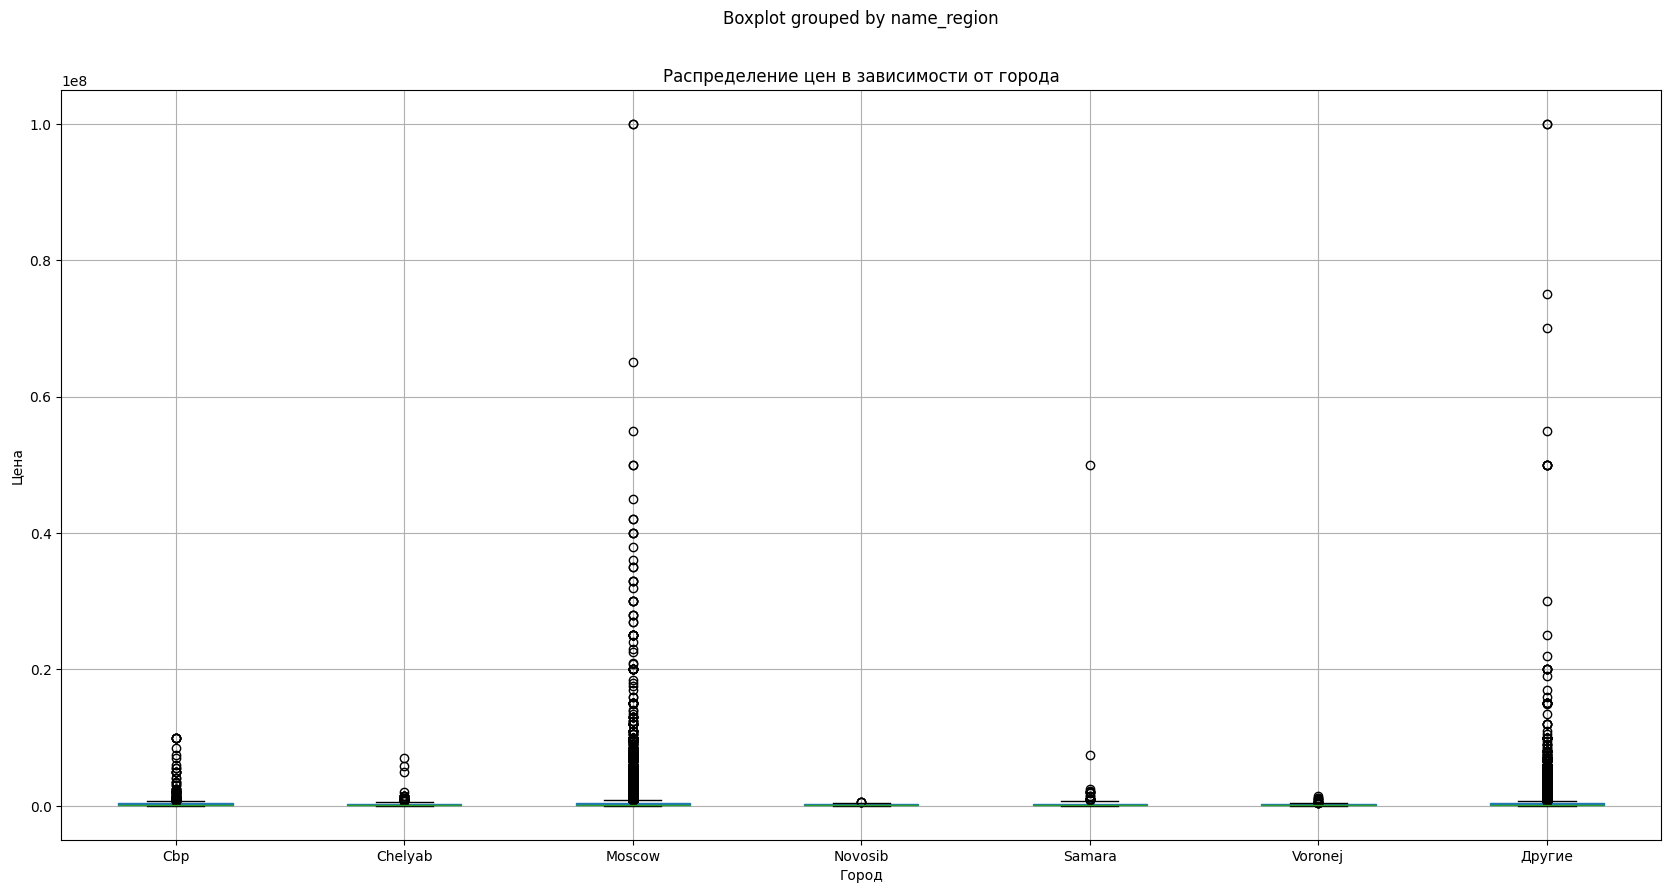

In [ ]:
def region(plate):
    return plate[-3:] if plate[-3:].isdigit() else ("0" + plate[-2:])

data["region"] = data["plate"].apply(region)

def main_region(plate):
    if plate in ["077", "097", "099", "177", "197", "199", "777", "797", "799", "977"]:
        return "Moscow"
    elif plate in ["078", "098", "178", "198"]:
        return "Cbp"
    elif plate in ["053"]:
        return "Novosib"
    elif plate in ["074", "174", "774"]:
        return "Chelyab"
    elif plate in ["063", "163", "763"]:
        return "Samara"
    elif plate in ["036", "136"]:
        return "Voronej"
    else:
        return "Другие"

data["name_region"] = data["region"].apply(main_region)

ax = data.boxplot(column="price", by="name_region", figsize=(20, 10), patch_artist=True)
ax.set_title("Распределение цен в зависимости от города")
ax.set_xlabel("Город")
ax.set_ylabel("Цена")

Text(0, 0.5, 'Цена')

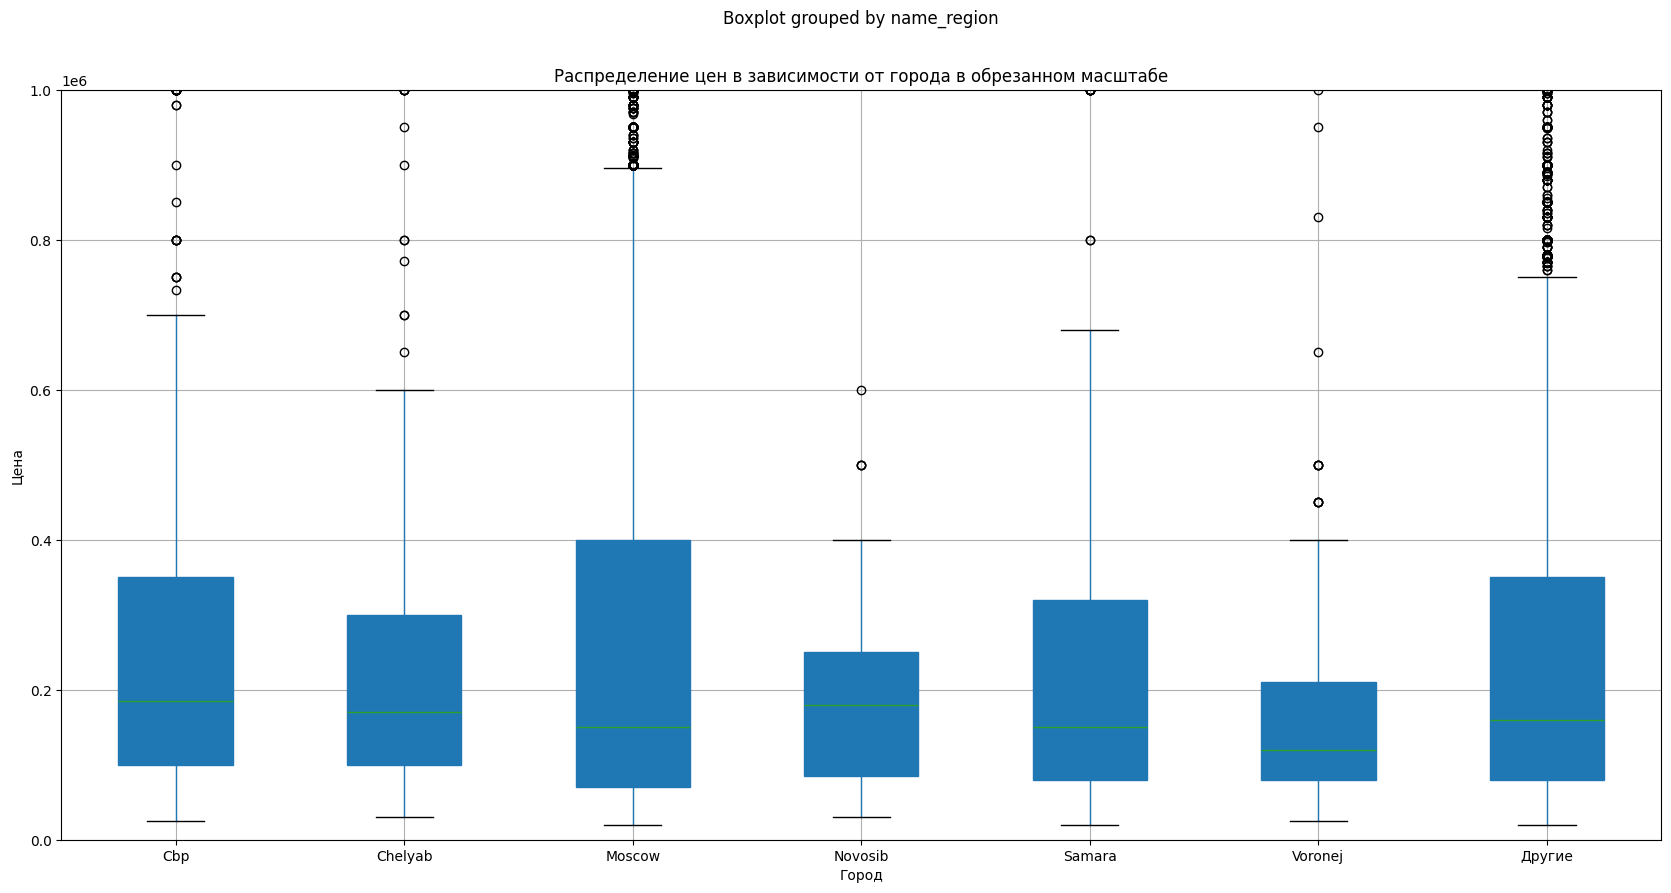

In [ ]:
ax = data.boxplot(column="price", by="name_region", figsize=(20, 10), patch_artist=True)
ax.set_ylim(0, 0.1 * 10**7)
ax.set_title("Распределение цен в зависимости от города в обрезанном масштабе")
ax.set_xlabel("Город")
ax.set_ylabel("Цена")


---



#ИМПОРТИРУЕМ БИБЛИОТЕКУ DATETIME, ЧТОБЫ РАБОТАТЬ СО ВРЕМЕНЕМ. ИДЕЯ: ОТБРОСИТЬ ВСЕ СТАРЫЕ ПОКУПКИ, ЭТО СВЯЗАНО С ИНФЛЯЦИЕЙ ЦЕН И ТЕМ ФАКТОМ, ЧТО НАС ИНТЕРЕСУЕТ ЦЕНА В ДАННЫЙ МОМЕНТ ВРЕМЕНИ

In [ ]:
current_data = datetime.now()

def data_transform(date_in_data):
    difference_in_time = str(current_data - datetime.strptime(date_in_data, "%Y-%m-%d %H:%M:%S")).split()[0]
    return int(difference_in_time)
data["date"] = data["date"].apply(data_transform)

In [ ]:
data = data.loc[data.groupby("plate")["date"].idxmin()]

In [ ]:
print(len(data["plate"]) - len(set(data["plate"])))

0


In [ ]:
data.isnull().sum()

,0
id,0
plate,0
date,0
price,0
region,0
name_region,0


#ПРОПУЩЕННЫХ ЗНАЧЕНИЙ НЕТ

In [ ]:
data.describe()

,id,date,price
count,43605.000000,43605.000000,4.360500e+04
mean,25813.128678,351.003784,4.384232e+05
std,14909.072004,325.842551,1.834132e+06
min,1.000000,35.000000,2.000000e+04
25%,12949.000000,76.000000,7.000000e+04
50%,25789.000000,232.000000,1.500000e+05
75%,38729.000000,557.000000,3.500000e+05
max,51635.000000,1490.000000,1.000000e+08


<ipython-input-223-db8040c463b7>:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


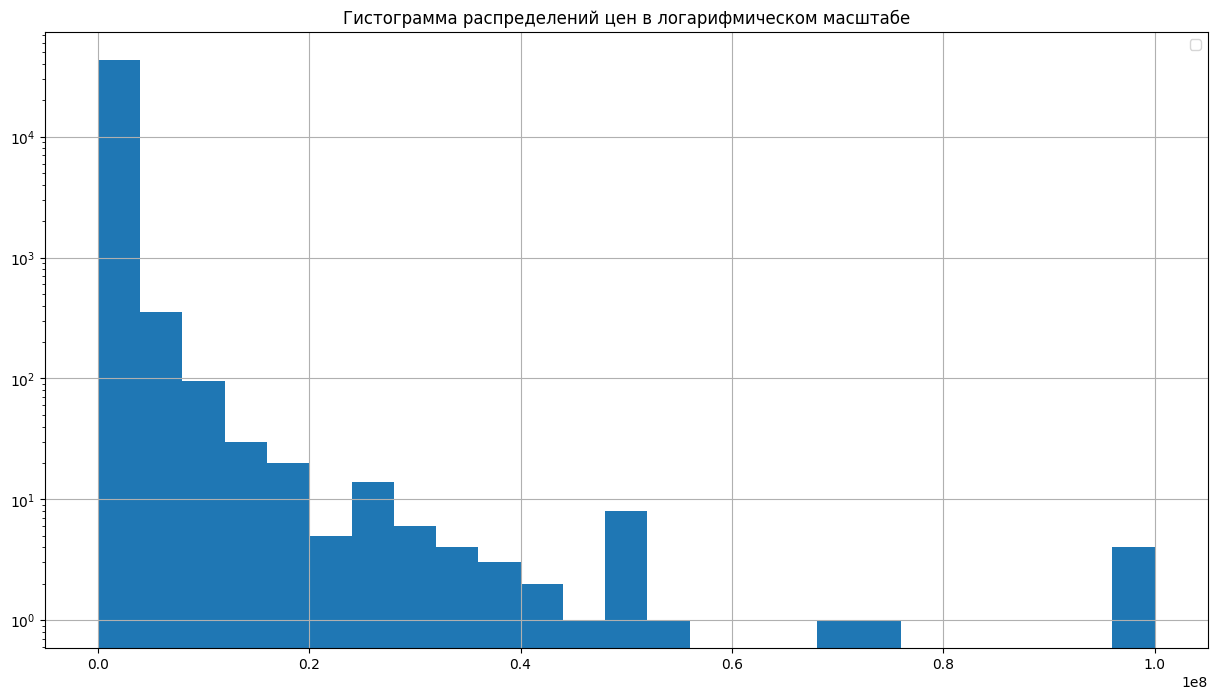

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(data["price"], bins=25, log=True)
plt.title("Гистограмма распределений цен в логарифмическом масштабе")
plt.legend()
plt.grid(True)


---
#ПОСМОТРИМ НА САМЫЕ НИЗКИЕ И НА САМЫЕ ВЫСОКИЕ ЦЕНЫ


In [ ]:
data[data["price"] == max(data["price"])]

,id,plate,date,price,region,name_region
43878,43879,B777CY77,229,100000000,077,Moscow
1794,1795,K252KK777,156,100000000,777,Moscow
21108,21109,M026MM08,354,100000000,008,Другие
47081,47082,X777XX05,268,100000000,005,Другие


In [ ]:
data[data["price"] == min(data["price"])]

,id,plate,date,price,region,name_region
27317,27318,A533MM702,508,20000,702,Другие
34078,34079,B904OX797,463,20000,797,Moscow
48328,48329,E307KE37,1037,20000,037,Другие
31797,31798,H202EB63,737,20000,063,Samara
16502,16503,K002BY197,802,20000,197,Moscow
41754,41755,K053YM777,994,20000,777,Moscow
19292,19293,K963OK797,463,20000,797,Moscow
38220,38221,O494TP193,347,20000,193,Другие
37652,37653,O780BX799,463,20000,799,Moscow
47329,47330,P494MO777,1159,20000,777,Moscow


In [ ]:
data.shape

(43605, 6)



---
#ИДЕЯ В ТОМ , ЧТОБЫ КАЖДЫЙ НОМЕР РАЗОБРАТЬ НА КОЛИЧЕСТВО ПОВТОРЯЮЩИХСЯ ЭЛЕМЕНТОВ. ВИДНО ЧТО САМЫМИ ДОРОГИМИ НОМЕРАМИ ЯВЛЯЮТСЯ НОМЕРА ИМЕЮЩИЕ ПОВТОРЯЮЩИЕСЯ БУКВЫ И ЦИФРЫ

#РАЗРАБОТАЕМ АНАЛОГ ONE-HOT-ENCODER'а

In [ ]:
data["Triplet_letters"] = 0
data["Double_letters"] = 0
data["Single_letters"] = 0
data["Sixtet_numbers"] = 0
data["Kvintet_numbers"] = 0
data["Quartet_number"] = 0
data["Triplet_numbers"] = 0
data["Doublet_numbers"] = 0
data["Singlet_numbers"] = 0

for index, plate_in in data[["id", "plate"]].iterrows():
    letter_count = {}
    number_count = {}

    for char in plate_in['plate']:
        if char.isdigit():
            number_count[char] = number_count.get(char, 0) + 1
        else:
            letter_count[char] = letter_count.get(char, 0) + 1

    for let, seq in letter_count.items():
        if seq == 3:
            data.loc[index, "Triplet_letters"] += 1
        elif seq == 2:
            data.loc[index, "Double_letters"] += 1
        elif seq == 1:
            data.loc[index, "Single_letters"] += 1

    for num, seq in number_count.items():
        if seq == 6:
            data.loc[index, "Sixtet_numbers"] += 1
        elif seq == 5:
            data.loc[index, "Kvintet_numbers"] += 1
        elif seq == 4:
            data.loc[index, "Quartet_number"] += 1
        elif seq == 3:
            data.loc[index, "Triplet_numbers"] += 1
        elif seq == 2:
            data.loc[index, "Doublet_numbers"] += 1
        elif seq == 1:
            data.loc[index, "Singlet_numbers"] += 1

    data.shape
    letter_count.clear()
    number_count.clear()

In [ ]:
data.sample(6)

,id,plate,date,price,region,name_region,Triplet_letters,Double_letters,Single_letters,Sixtet_numbers,Kvintet_numbers,Quartet_number,Triplet_numbers,Doublet_numbers,Singlet_numbers
22301,22302,H065TO797,106,75000,797,Moscow,0,0,3,0,0,0,0,1,4
34959,34960,O010BY50,934,300000,050,Другие,0,0,3,0,0,0,1,0,2
6588,6589,X831CT797,44,60000,797,Moscow,0,0,3,0,0,0,0,1,4
13086,13087,O151CT797,39,60000,797,Moscow,0,0,3,0,0,0,0,2,2
31767,31768,H080HE799,371,50000,799,Moscow,0,1,1,0,0,0,0,2,2
19163,19164,C077YM790,44,95000,790,Другие,0,0,3,0,0,0,1,1,1


In [ ]:
data.head(4)

,id,plate,date,price,region,name_region,Triplet_letters,Double_letters,Single_letters,Sixtet_numbers,Kvintet_numbers,Quartet_number,Triplet_numbers,Doublet_numbers,Singlet_numbers
22915,22916,A001AA197,138,1000000,197,Moscow,1,0,0,0,0,0,0,2,2
18156,18157,A001AA75,302,10000000,075,Другие,1,0,0,0,0,0,0,1,3
45108,45109,A001AA97,121,15000000,097,Moscow,1,0,0,0,0,0,0,1,3
24783,24784,A001AE123,291,3500000,123,Другие,0,1,1,0,0,0,0,2,2


#ПОСМОТРИМ НА МАТРИЦУ КОРЕЛЯЦИЙ , ЧТОБЫ УДОСТОВЕРИТЬСЯ В ГИПОТЕЗЕ О СВЯЗИ ЧАСТОТЕ БУКВ И ЦИФР С ЦЕНОЙ НА НОМЕР

In [ ]:
data = data.drop(["id", "plate", "date", "region", "name_region"], axis=1)

<Axes: >

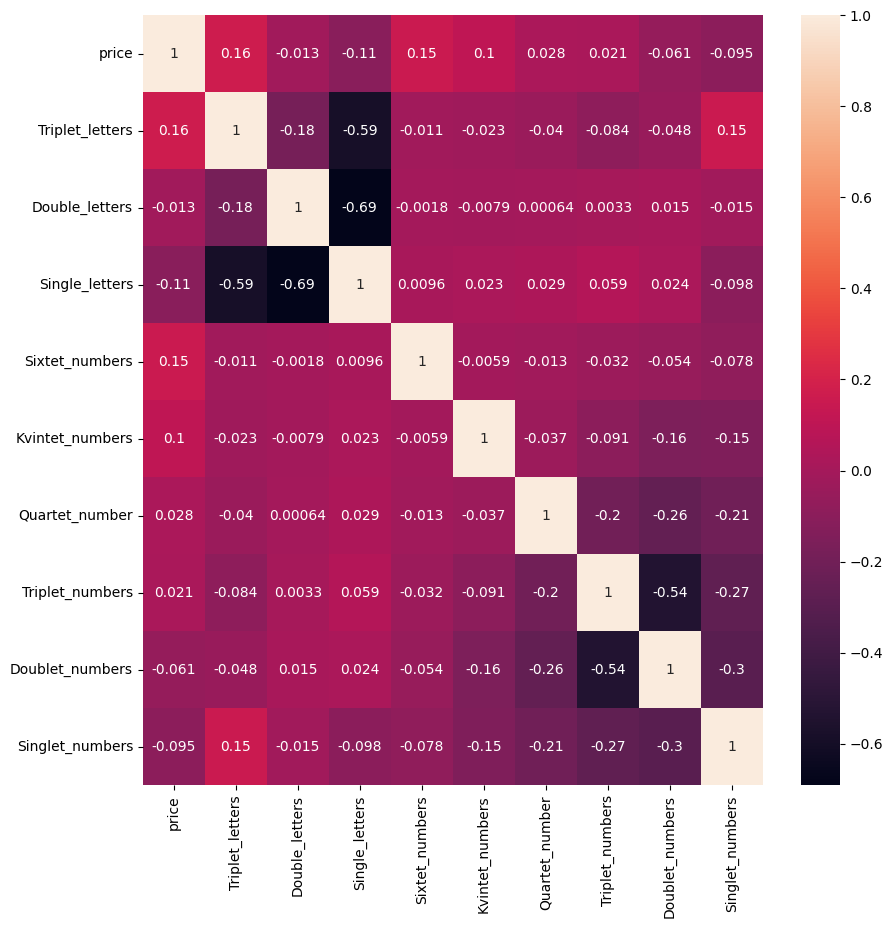

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(data=data.corr(), annot=True)



---
#ПЕРЕЙДЁМ К ПОДБОРУ МОДЕЛИ И ГИПЕРПАРАМЕТРОВ. РАЗОБЬЁМ ДАННЫЕ НА ОБУЧАЮЩУЮ И ТЕСТОВУЮ ВЫБОРКИ , ЧТОБЫ ОЦЕНИТЬ РАБОТОСПОСОБНОСТЬ МОДЕЛИ


In [ ]:
data, y = data.drop(["price"], axis=1), data["price"]

In [ ]:
data.head(4)

,Triplet_letters,Double_letters,Single_letters,Sixtet_numbers,Kvintet_numbers,Quartet_number,Triplet_numbers,Doublet_numbers,Singlet_numbers
22915,1,0,0,0,0,0,0,2,2
18156,1,0,0,0,0,0,0,1,3
45108,1,0,0,0,0,0,0,1,3
24783,0,1,1,0,0,0,0,2,2


In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(data, y, test_size = 0.2, shuffle=True)
dtree = DecisionTreeRegressor()

param_grid3 = {
    "criterion":["squared_error", "absolute_error"],
    "max_depth":[10, 12, 14],
    "min_samples_split":[12, 15, 17],
    "min_samples_leaf":[1, 2],
}
grid_search3 = GridSearchCV(dtree, param_grid3, cv=3)
grid_search3.fit(xtrain, ytrain)
print("Best parametrs of Decision Tree", grid_search3.best_params_)
best_Dtree = grid_search3.best_estimator_
#dtree.fit(data, y)
print(mean_absolute_percentage_error(ytest, best_Dtree.predict(xtest)))

Best parametrs of Decision Tree {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 15}
2.0108262436047877


In [ ]:
RFS = RandomForestRegressor()
param_grid2 = {
    "n_estimators": [1, 2, 4, 10],
    "max_depth": [20, 25, 30, 35, 40],
    "min_samples_split":[15, 20, 25],
    "min_samples_leaf":[1, 2, 3]
}
grid_search2 = GridSearchCV(estimator=RFS, param_grid=param_grid2, cv=5)
grid_search2.fit(xtrain, ytrain)
print("Best parametrs of RFS ", grid_search2.best_params_)
best_rf = grid_search2.best_estimator_
print(mean_absolute_percentage_error(ytest, best_rf.predict(xtest)))

Best parametrs of RFS  {'max_depth': 25, 'min_samples_leaf': 3, 'min_samples_split': 25, 'n_estimators': 4}
1.9964369668700412


In [ ]:
ModelXGB = xgb.XGBRegressor()

param_grid = {
    "n_estimators": [250, 300],
    "max_depth": [7, 10, 15],
    "learning_rate": [0.01, 0.013],
    "subsample": [0.6, 0.8],
    "colsample_bytree": [0.33, 0.66, 1.0]
}
grid_search = GridSearchCV(estimator=ModelXGB, param_grid=param_grid, cv=5)
grid_search.fit(xtrain, ytrain)
best_model = grid_search.best_estimator_
print("The best parametrs: ", grid_search.best_params_)
print("MAPE: ",mean_absolute_percentage_error(ytest, best_model.predict(xtest)))

The best parametrs:  {'colsample_bytree': 0.66, 'learning_rate': 0.013, 'max_depth': 10, 'n_estimators': 300, 'subsample': 0.6}
MAPE:  2.108781337738037


P.S. На деле я пробовал кууудаа больше гиперпараметров

---



#ДАЛЕЕ ПОДГРУЖАЕМ ТЕСТОВЫЕ ДАННЫЕ , ДЛЯ УЧАСТИЯ В СОРЕВНОВАНИИ НА KAGGLE

In [ ]:
test_data = pd.read_csv("test.csv")
tt = test_data.copy()


test_data["Triplet_letters"] = 0
test_data["Double_letters"] = 0
test_data["Single_letters"] = 0
test_data["Sixtet_numbers"] = 0
test_data["Kvintet_numbers"] = 0
test_data["Quartet_number"] = 0
test_data["Triplet_numbers"] = 0
test_data["Doublet_numbers"] = 0
test_data["Singlet_numbers"] = 0

for index, plate_in in enumerate(test_data["plate"]):
    letter_count = {}
    number_count = {}

    for char in plate_in:
        if char.isdigit():
            number_count[char] = number_count.get(char, 0) + 1
        else:
            letter_count[char] = letter_count.get(char, 0) + 1

    for let, seq in letter_count.items():

        if seq == 3:
            test_data.at[index, "Triplet_letters"] += 1
        elif seq == 2:
            test_data.at[index, "Double_letters"] += 1
        elif seq == 1:
            test_data.at[index, "Single_letters"] += 1

    for num, seq in number_count.items():

        if seq == 6:
            test_data.at[index, "Sixtet_numbers"] += 1
        elif seq == 5:
            test_data.at[index, "Kvintet_numbers"] += 1
        elif seq == 4:
            test_data.at[index, "Quartet_number"] += 1
        elif seq == 3:
            test_data.at[index, "Triplet_numbers"] += 1
        elif seq == 2:
            test_data.at[index, "Doublet_numbers"] += 1
        elif seq == 1:
            test_data.at[index, "Singlet_numbers"] += 1

    test_data.shape
    letter_count.clear()
    number_count.clear()

test_data = test_data.drop(["id", "plate", "date", "price"], axis=1)

In [ ]:
test_data.head(3)

,Triplet_letters,Double_letters,Single_letters,Sixtet_numbers,Kvintet_numbers,Quartet_number,Triplet_numbers,Doublet_numbers,Singlet_numbers
0,0,1,1,0,0,0,1,1,1
1,0,0,3,0,0,0,0,1,4
2,0,0,3,0,0,0,2,0,0


In [ ]:
rfs = RandomForestRegressor(max_depth=25, min_samples_leaf=3, min_samples_split=25, n_estimators=4)
rfs.fit(data, y)

RandomForestRegressor(max_depth=25, min_samples_leaf=3, min_samples_split=25,
                      n_estimators=4)

In [ ]:
tt["price"] = rfs.predict(test_data)

In [ ]:
tt.head(4)

,id,price
0,51636,325895.943330
1,51637,122117.489577
2,51638,612285.098967
3,51639,325895.943330


In [ ]:
tt = tt.drop(["plate", "date"], axis=1)
tt.to_csv("Result.csv", index=False)
